<a href="https://colab.research.google.com/github/Trickshotblaster/nn-practices/blob/main/TransformerV3TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
raw_text = requests.get(url).text

In [ ]:
train_amount = 0.9
train_text, val_text = raw_text[:int(len(raw_text) * train_amount)], raw_text[int(len(raw_text) * train_amount):]
train_text[:100]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

In [ ]:
vocab = set(raw_text)
vocab.add("<|UNK|>")
vocab = sorted(vocab)

stoi = {char:i for i, char in enumerate(vocab)}
itos = {i:char for i, char in enumerate(stoi)}
itos[stoi['<|UNK|>']]

'<|UNK|>'

In [ ]:
class Tokenizer:
  def __init__(self, stoi, itos):
    self.stoi = stoi
    self.itos = itos
  def __len__(self):
    return len(self.stoi) - 1
  def encode(self, text):
    return [stoi.get(char, stoi['<|UNK|>']) for char in text]
  def decode(self, tokens):
    return "".join([itos.get(token, '<|UNK|>') for token in tokens])
tokenizer = Tokenizer(stoi, itos)
tokenizer.decode(tokenizer.encode("hello world ^}|%"))

'hello world <|UNK|><|UNK|><|UNK|><|UNK|>'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

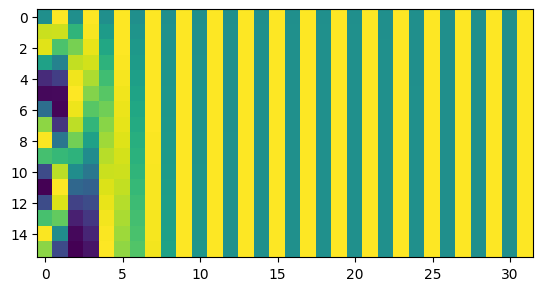

In [ ]:
max_seq_len = 16
emb_dim = 32
import math
def create_positional_encoding_matrix(max_seq_len, emb_dim):
  mask = torch.zeros((max_seq_len, emb_dim))
  for pos in range(max_seq_len):
    for i in range(0, emb_dim, 2):
      mask[pos, i] = math.sin(pos/(10000 ** ((2*i)/emb_dim)))
      mask[pos, i+1] = math.cos(pos/(10000 ** ((2*(i+1))/emb_dim)))
  return mask
positional_encoding_matrix = create_positional_encoding_matrix(max_seq_len, emb_dim)
import matplotlib.pyplot as plt
plt.imshow(positional_encoding_matrix.numpy())

In [ ]:
class MaskedMultiHeadAttention(nn.Module):
  def __init__(self, n_heads, emb_dim):
    super().__init__()
    assert emb_dim % n_heads == 0, "Embedding dimension must be divisible by head number"
    self.n_heads = n_heads
    self.emb_dim = emb_dim
    self.head_size = emb_dim // n_heads
    self.wq = nn.Linear(emb_dim, emb_dim)
    self.wk = nn.Linear(emb_dim, emb_dim)
    self.wv = nn.Linear(emb_dim, emb_dim)

    self.wo = nn.Linear(emb_dim, emb_dim)
  def forward(self, x):
    batch_size, seq_len, emb_dim = x.size()
    Q = self.wq(x).view(batch_size, seq_len, self.n_heads, self.head_size).transpose(1, 2)
    K = self.wk(x).view(batch_size, seq_len, self.n_heads, self.head_size).transpose(1, 2)
    V = self.wv(x).view(batch_size, seq_len, self.n_heads, self.head_size).transpose(1, 2)

    scaled_dot_product = (torch.matmul(Q, K.transpose(2, 3)))/(self.head_size**0.5)

    attn_mask = torch.triu(
        torch.ones(seq_len, seq_len),
        diagonal=1
    ).to(device)
    attn_mask.masked_fill_(attn_mask==1, float('-inf'))

    scaled_dot_product += attn_mask

    attn_scores = torch.matmul(F.softmax(scaled_dot_product, dim=-1), V)
    attn_scores = attn_scores.view(batch_size, -1, self.n_heads * self.head_size)

    out = self.wo(attn_scores)

    return out # (batch_size, seq_len, emb_dim)


tensor([[[ 2.3461e-01,  4.9978e-01, -5.8001e-02,  9.7791e-02,  3.8873e-02,
          -2.7843e-01, -1.8957e-01,  5.1536e-02, -1.8104e-01,  7.1944e-03,
           7.9413e-03,  2.8555e-01,  7.8404e-02, -9.6415e-02,  3.7422e-02,
          -1.3509e-01,  2.6016e-01, -2.1465e-02,  9.6084e-02,  5.3424e-02,
           6.5205e-02,  3.1046e-01,  2.9622e-01, -2.0063e-01,  2.3900e-01,
           1.2731e-01, -8.4547e-02,  6.0434e-03, -9.0917e-02,  6.0460e-02,
          -6.0112e-02,  1.4407e-01],
         [ 2.1582e-01,  5.1136e-01, -8.1883e-02,  9.1253e-02,  8.4480e-02,
          -2.7785e-01, -1.8405e-01,  7.4366e-02, -2.1105e-01, -1.9305e-02,
          -2.7408e-02,  2.6630e-01,  9.8041e-02, -6.4037e-02,  1.1066e-01,
          -9.0400e-02,  2.6965e-01, -5.9027e-02,  7.0760e-02,  7.8228e-02,
           9.3511e-02,  2.9761e-01,  3.1977e-01, -1.7494e-01,  2.2251e-01,
           1.3551e-01, -1.0322e-01,  7.8441e-03, -1.5735e-01,  4.0059e-02,
          -8.3660e-02,  1.4393e-01],
         [ 1.7759e-01,  3.

In [ ]:
class MLP(nn.Module):
  def __init__(self, in_size, hidden_size, out_size):
    super().__init__()
    self.l1 = nn.Linear(in_size, hidden_size)
    self.l2 = nn.Linear(hidden_size, out_size)
    self.act = nn.GELU()
  def forward(self, ins):
    hidden = self.act(self.l1(ins))
    return self.act(self.l2(hidden))

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, n_heads, emb_dim):
    super().__init__()
    self.layernorm = nn.LayerNorm(emb_dim)
    self.n_heads = n_heads
    self.emb_dim = emb_dim
    self.MHA = MaskedMultiHeadAttention(n_heads, emb_dim)
    self.MLP = MLP(emb_dim, emb_dim * 4, emb_dim)
  def forward(self, ins):
    residual = ins.clone()
    attention_result = self.MHA(ins)
    attention_result += residual
    normalized_attention_result = self.layernorm(attention_result)
    residual2 = normalized_attention_result.clone()
    MLP_out = self.MLP(normalized_attention_result)
    MLP_out += residual2
    out = self.layernorm(MLP_out)
    return out


tensor([[[ 0.3480,  1.4857, -0.6613, -0.1879, -0.4310,  0.6775, -1.0171,
           0.5601,  0.4434,  0.0724, -1.6670,  1.0363,  0.6657, -1.2474,
          -0.5774, -1.4791,  1.1693,  0.5102, -0.5863,  1.3048,  0.1757,
           1.5577,  0.5967,  0.1966,  0.0292, -0.6843, -0.1641, -1.3997,
          -1.7510,  2.3677, -0.8653, -0.4783],
         [-0.6586,  0.1690,  0.2151,  0.1472, -0.9148,  2.0712, -0.3504,
           1.4613, -0.1667,  1.0654, -1.0099, -0.4491,  0.9314, -0.4997,
          -0.8162, -0.9806,  1.6746, -1.0379, -0.1951, -0.6157, -2.2204,
           0.1802,  1.0561,  1.6190, -0.0973,  0.4730,  1.3115, -0.7508,
          -1.7981, -0.2263,  0.3952,  0.0177],
         [ 0.6081,  0.2984, -1.5913, -1.2482,  1.1193,  1.2269,  0.7327,
          -1.2182,  0.1108,  0.1959, -0.8538,  0.7994, -0.5710,  1.5305,
           1.2279, -0.7629, -2.1865, -1.0441, -0.4247,  1.3450,  0.3511,
           0.2187, -0.0837, -0.5016,  0.4879,  0.3769, -1.0243,  1.3328,
          -0.5009, -0.2090, -1

In [ ]:
class GPT(nn.Module):
  def __init__(self, n_heads, emb_dim, max_seq_len, n_blocks, tokenizer):
    super().__init__()
    self.n_heads = n_heads
    self.emb_dim = emb_dim
    self.max_seq_len = max_seq_len
    self.n_blocks = n_blocks
    self.tokenizer = tokenizer
    self.layernorm = nn.LayerNorm(emb_dim)
    self.emb = nn.Embedding(len(tokenizer) + 1, emb_dim)
    self.pos_encoding_matrix = create_positional_encoding_matrix(max_seq_len, emb_dim).to(device)
    self.decoder_stack = nn.ModuleList([
        TransformerBlock(n_heads, emb_dim)
        for _ in range(n_blocks)
    ])

    self.logits_layer = nn.Linear(emb_dim, len(tokenizer)+1)
  def forward(self, ins):
    embedding = self.emb(ins)
    pos_encoding_indices = torch.arange(ins.shape[1]).to(device) # seq_len

    x = embedding
    x += self.pos_encoding_matrix[pos_encoding_indices]

    for decoder in self.decoder_stack:
      x = decoder(x)

    x = self.layernorm(x)
    logits = self.logits_layer(x)
    return logits
  @torch.no_grad()
  def generate(self, text, length=10):
    out = ""
    for x in range(length):
      encodings = torch.tensor(self.tokenizer.encode(text + out)).to(device)
      seq_len = len(encodings)
      if seq_len > self.max_seq_len:
        encodings = encodings[len(encodings) - self.max_seq_len:]
      tokens = encodings.view(1, -1)
      logits = self.forward(tokens)[0, -1, :] # logits for last char
      probs = F.softmax(logits, dim=-1)
      selection_index = torch.multinomial(probs, num_samples=1)
      out += self.tokenizer.decode([selection_index.item()])
    return out

In [ ]:
import torch
import torchvision
import torch_xla.core.xla_model as xm

In [ ]:
max_seq_len = 32
emb_dim = 32
n_heads = 8
n_blocks = 10

lr = 0.001
batch_size = 64
max_epochs = 3

log_period = 1000

device = xm.xla_device()#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


myGPT = GPT(n_heads, emb_dim, max_seq_len, n_blocks, tokenizer)
myGPT = myGPT.to(device)
print("Total params:", sum(p.numel() for p in myGPT.parameters()))
if torch.cuda.is_available():
  myGPT = torch.compile(myGPT, backend='aot_torchxla_trace_once')
optim = torch.optim.AdamW(myGPT.parameters(), lr=lr)

Total params: 130754


In [ ]:
def generate_dataset(max_seq_len, tokens):
  context_x = tokens[:max_seq_len]
  context_y = tokens[1:max_seq_len+1]
  x_examples = [context_x]
  y_examples = [context_y]
  for token, next in zip(tokens[max_seq_len:], tokens[max_seq_len+1:]):
    context_x = context_x[1:]
    context_x.append(token)
    context_y = context_y[1:]
    context_y.append(next)
    x_examples.append(context_x)
    y_examples.append(context_y)
  return torch.tensor(x_examples).long().to(device), torch.tensor(y_examples).to(device)
tokenized_train_data = tokenizer.encode(train_text)
Xtr, Ytr = generate_dataset(max_seq_len, tokenized_train_data)
tokenized_test_data = tokenizer.encode(val_text)
Xte, Yte = generate_dataset(max_seq_len, tokenized_test_data)
tokenizer.decode(Xtr[0].cpu().numpy()), tokenizer.decode(Ytr[0].cpu().numpy())

('First Citizen:\nBefore we proceed', 'irst Citizen:\nBefore we proceed ')

In [ ]:
train_len = len(Xtr) - 1
max_steps = (train_len // batch_size) * max_epochs
for step in range(max_steps): # max_steps
  batch_indices = torch.randint(0, train_len, (batch_size,)).to(device)
  x_batch = Xtr[batch_indices]
  y_batch = Ytr[batch_indices].view(-1)

  logits = myGPT(x_batch)
  logits = logits.view(-1, logits.size(-1))
  loss = F.cross_entropy(logits, y_batch)
  optim.zero_grad()
  loss.backward()
  optim.step()

  if step % log_period == 0:
    print("Step", str(step) + ", loss:", loss.item())

Step 0, loss: 4.462635040283203
Step 1000, loss: 0.09450148791074753
Step 2000, loss: 0.0831683948636055
Step 3000, loss: 0.06723348051309586
Step 4000, loss: 0.0618027001619339
Step 5000, loss: 0.06486377865076065
Step 6000, loss: 0.05567563325166702
Step 7000, loss: 0.06839106231927872
Step 8000, loss: 0.05807604268193245
Step 9000, loss: 0.06374622881412506
Step 10000, loss: 0.057793326675891876
Step 11000, loss: 0.04828006401658058
Step 12000, loss: 0.0573645643889904
Step 13000, loss: 0.05887402594089508
Step 14000, loss: 0.061360716819763184
Step 15000, loss: 0.059712402522563934
Step 16000, loss: 0.0519883818924427
Step 17000, loss: 0.06995172053575516
Step 18000, loss: 0.048565030097961426
Step 19000, loss: 0.0469779372215271
Step 20000, loss: 0.050306953489780426
Step 21000, loss: 0.0665665790438652
Step 22000, loss: 0.05625740811228752
Step 23000, loss: 0.051283299922943115
Step 24000, loss: 0.047473613172769547
Step 25000, loss: 0.04904669523239136
Step 26000, loss: 0.051967

In [ ]:
print(myGPT.generate("\n", length=500))







UKDDLinLLDLO
ERDTAce:ARELELY:
Sissy, sir!

MENENIUS:
You wife, met, before to a- wing as non!

CALIOPY:
What I cravented cose
Is them's roveness.

GLOUCESTER:
Voot, I carrant your from a sains,
Killowing secreat.

CAPHARD:
Here comes be in the gove and the ministed
Well not ressed, herl, my lease:
 here, as bless, thou mewly to thou have thhe broopt. Murder,
Sadmon that for such A gerre any
To king sent buckingue!
Hall consportune for.

Second Seport.
But a do impossing my long place;
Fein
